# An Analasis of Boston Marathon Race Results
## By Elliot Hayes

# Introduction

In this project we will be analyzing the results from the past 10 Boston marathons. The data that we will be looking at comes from the Boston marathon official website which allows you to search official race results. See http://registration.baa.org/2009/cf/Public/iframe_ResultsSearch.cfm?mode=entry for results from the 2009 Boston marathon for an example of the data we will be using. In this project we will collect these search results, and analyze them. We will focus mainly on the effects of age on marathon time and participation. At the end of this document we will discuss some potential methods of analysis that could be used to better understand the data in the future. 

# Importance
The information that we are looking at has many potential uses. Two impactful uses would be to improve marketing strategies, and to improve public health. This analysis could be taken into acount by companies who have products that are targeted towards runners. Being able to understand the audince that they are selling to would allow them to better target promote their products and allow them to identify where they can improve their marketing strategies. See https://www.referralcandy.com/blog/nike-marketing-strategy/ for more information about how companies are able to target specific audiences. This analysis could also be used when considering how to improve public health. If we are able to understand what motivates people to be active and participate in activities such as running that lead to a healthier lifestlye could help shape strategies that encourage the general public to improve their health. See https://www.tandfonline.com/doi/abs/10.1080/02701367.1991.10608701 for more information on why physical activity is important for public health. 

# Packages
The packages that we will be using in this analysis are included in the code below. Some of the notable packages include:
 - requests -> used to send html requests to construct the dataset
 - bs4 -> used to parse the html gotten from requests
 - pandas -> used for data storage and data processing
 - matplotlib -> used to visualize and understand the data that we collect


In [7]:
#Packages used to obtain the dataset
import time
import requests
from bs4 import BeautifulSoup
from threading import Thread

#Packages used to work with the dataset
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

# Datasource

http://registration.baa.org/2009/cf/Public/iframe_ResultsSearch.cfm?mode=entry

As mentioned previously, we will be scraping data from the Boston marathon official results website. The data that we will get from there includes : Bib number, runner name, runner age, gender, home city, home state, home country,	citizen, 5k split, 10k split, 15k split, 20k split, Half split, 25k split, 30k split, 35k split, 40k split, Finish time, average pace,	predicted finish time, official finish time, overall finish position, gender finish position, and age group finish position. 

In this analysis we will be focusing mostly on the runner's age and finish time, but there is potential for much more analysis which we will discuss in the further analysis section. 

# Gathering the data
This is the most challenging part of this analysis as the data is not provided in a manner that was easy or simple to collect.

To gather the data we first need to initialize a few variables. 

The mypath variable is used to store the data that we scrape after we finish collecting it.

The gender variable is used as a parameter in the searches we will perform

The number_of_results variable is used to specify the maximum number of results that we receive for a given year. Since there have never been more than 60,000 finishers of the Boston marathon for a given year, we assigned that value to number_of_results.


In [3]:
#Path where the data will be stored as a csv file
mypath ='C:/Users/Hi/Python'

#Parameters in the search query, gender = 0 -> both genders are included, results = 60000 -> up to 60000 results will be obtained per year
gender = 0
number_of_results = 60000

results = []

We need a dictionary that contains information that will be used to form a header for our http requests. This is necessary so that the website we are collecting data from does not refuse to acknowledge our http request. Including a header reduces the probability that we will be flagged as suspicious or have our requests ignored. We will call this dictionary "headers". 

We also need a dictionary that contains the parameters of the searches that we will be executing. This includes values such as what gender the runner is, what country they are from, what age they are, etc... The values in this dictionary are set so that our search is as broad as possible and will match every runner. We will call this dictionary params. 

See https://2.python-requests.org/en/master/user/quickstart/#custom-headers for more information about headers, params, and data dictionaries for post requests in Python.

In [2]:
#Headers used to send http post requests
headers = {'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
           'Accept-Encoding': 'gzip, deflate',
           'Accept-Language': 'en-US,en;q=0.9',
           'Cache-Control': 'max-age=0',
           'Connection': 'keep-alive',
           'Content-Type': 'application/x-www-form-urlencoded',
           'Host': 'registration.baa.org',
           'Origin': 'http://registration.baa.org',
           'Referer': 'http://registration.baa.org/2019/cf/Public/iframe_ResultsSearch.cfm',
           'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.142 Mobile Safari/537.36'}
    
#Parameters that can be specified for the search 
#Finding the exact parameters to perform a search was one of the most difficult parts of this project, along with parsing the
#data we want from the html string.
params = {'mode': 'results','criteria': '','StoredProcParamsOn': 'yes','VarGenderID': 0,'VarBibNumber': '','VarLastName': '','VarFirstName': '','VarStateID': 0,'VarCountryOfResID': 0,'VarCountryOfCtzID': 0,'VarReportingSegID': 1,'VarAwardsDivID': 0,'VarQualClassID': 0,'VarCity': '','VarTargetCount': number_of_results,'records': 50,'headerexists': 'Yes','bordersize': 0,'bordercolor': '#ffffff','rowcolorone': '#FFCC33','rowcolortwo': '#FFCC33','headercolor': '#ffffff','headerfontface': 'Verdana,Arial,Helvetica,sans-serif','headerfontcolor': '#004080','headerfontsize': '12px','fontface': 'Verdana,Arial,Helvetica,sans-serif','fontcolor': '#000099','fontsize': '10px','linkfield': 'FormattedSortName','linkurl': 'OpenDetailsWindow','linkparams': 'RaceAppID','queryname': 'SearchResults','tablefields': 'FullBibNumber,FormattedSortName,AgeOnRaceDay,GenderCode,City,StateAbbrev,CountryOfResAbbrev,CountryOfCtzAbbrev,DisabilityGroup'}

Once we have the values that we want to use in our http requests, we can start thinking about how to get the information. For each year of the boston marathon there are roughly 30,000 runners who participate in the race, this means that there are ~12,000 pages of results that we need to gather and parse for 10 years of data. Since each requests takes ~1-5 seconds to complete this would mean that running this program would take ~5-10 hours to complete if we did not find a better way to obtain the data.

We also run into the problem that the website will blacklist our ip address if we send too many requests through the same connection.

To address both of these issues we use multithreading. We will initialize 10 different threads to gather the data. Each thread will be collecting all of the data for a single year. This reduces the runtime of the search down to ~1 hour (runtime depends highly on bandwidth). It also avoids the issue of being blacklisted and prevented for doing more searches.

Since the post request and data processing is relatively slow we do not include a sleep command to slow down the code (see commented code for time delay).

The main idea of the code below is to first get a page containing 25 marathon results, parse the information that we want from that page via beautifulsoup, then add it to a global results list (which needs to be thread safe or we would run into datarace issues). Once the page is parsed and stored we request another page. We continue this process until there are no more results for that year.  

See code below for specifics on how the data was extracted from html string. 

See https://www.crummy.com/software/BeautifulSoup/bs4/doc/ for more information on how to use Beautiful Soup. 

In [40]:
#Get year function parses all of the results for a given year and adds them to the results list
def get_year(year) :
    #page stores the number of pages that we have already visited, used to ensure that the program is running correctly (there are up to 1400 pages of results per year)
    page = 1
    #result stores the number of results that we have already visited, used to form the post request
    result = 1
   
    #Initial post request used to satisfy the while loop condition
    response = requests.post('http://registration.baa.org/' + str(year[0]) + '/cf/Public/iframe_ResultsSearch.cfm',headers=headers,params=params,data={'start': str(result), 'next': 'Next 25 Records'})
            
    while('Next 25 Records' in response.text):
            print("year:" + str(year[0]) + " page: " + str(page))
            
            #Send an html post request to get the next set of 25 results for the given year (specified by the data dictionary)
            response = requests.post('http://registration.baa.org/' + str(year[0]) + '/cf/Public/iframe_ResultsSearch.cfm', headers=headers, params=params, data={'start': str(result), 'next': 'Next 25 Records'})
            #Slow down the program to avoid havining our ip banned from performing any more searches
#           time.sleep(1)

            #Increment the number of results seen and the page number
            result += 25
            page += 1
            
            #Create a soup object out of the html
            soup = BeautifulSoup(response.text, "lxml")
            
            #Get the tags that contain the information we want
            table = soup.find("table", {"class": "tablegrid_table"})
            rows = table.findAll("tr")
            
            
            for row in rows:
                #to_append contains the rows that have information we are interested in
                to_append = []
                
                #Iterate over all td tags
                for val in row.findAll("td"):
                    #Remove all unnecessary characters from the tag (There were a lot of newlines and \r characters)
                    content = val.text.strip()[0:] #[0:] is included to prevent issues with unicode and ascii characters
                    #Add the parsed data to the list of values to append to results
                    to_append.append(content)
                
                #Make sure that there was actually data in the tag that we parsed
                invalid = False
                invalid = (len(to_append) == 1 and to_append[0] == '') or (len(to_append) == 2 and to_append[0] == '' and to_append[1] == '') or (len(to_append) == 3 and to_append[0] == '' and to_append[1] == '' and to_append[2] == '')
                
                #If there is valid data in the to append list, append it to results
                if (len(to_append) > 0 and not invalid) :
                    results.append(to_append)

Now that we have a function to send requests and collect the data via multithreading, we need to create and start the threads. In the following code we do that then wait for all the data to be collected. This is the longest stage of the data gathering process. 

In [ ]:
#The website has data starting from 2009

#To gather the data I use 10 threads, one for each year. This is to speed up the data collection and avoid being banned
#from making search queries. 
threads = [None] * len(range(2009, 2020))

#results stores the values that we will parse from the html string
results = []

#Start the threads
for year in range(2009, 2020):
    #There was an issue with the type of year, not sure if this fixed it or there was something else. 
    temp = year
    #Initialize thread
    threads[int(temp) - 2009] = Thread(target=get_year, args=([[temp]]))
    #Start thread
    threads[int(temp) - 2009].start()

#Wait for threads to finish (This takes a long time)
for year in range(2009, 2020):
    threads[year - 2009].join()
    

Once all the data is collected we get rid of unwanted data (table/column titles for each observation) then create a dataframe from the data that we collected. We write this data to a file so that we do not have to repeat the previous step.

In [ ]:
#We will use the data array to initialize a dataframe with the parsed information. 
data = []
i = 0

#Parse results
for result in results:
    #Each observation consists of 4 lists appended to results, we are only interested in the first 2
    if i%4 == 0:
        #Select only the first two tags of the td tags that we parsed. The other tags just contain the titles of the datafields
        data.append(results[i] + results[i+1][1:])
        
    i += 1
        
#Store the data in a dataframe then store it in a file so that we can access it later. 
df = pd.DataFrame.from_records(data)
df.to_csv(mypath + '/boston_marathon_results.csv', sep=',')

# Cleaning the dataset

Now that we have the data, we can start to clean it. As you can see in the cell below, we have 270,000 observations but a lot of them are not formatted as we expected. The website that we scraped the data from does not have a consistent html page so we will remove data that does not fit the format that we expected.

In [23]:
#Load the dataframe from a file (to avoid having to wait 10 hours to scrape the data again)
df = pd.read_csv(mypath + '/boston_marathon_results.csv', sep=',', low_memory=False)
print("Observations: " + str(len(df)))
df.head()

Observations: 272670


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
0,0,2,"Desisa, Lelisa",23,M,Ambo,NaN,ETH,NaN,NaN,...,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,19,"Kogo, Micah",26,M,Eldoret,NaN,KEN,NaN,NaN,...,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3,"Gebremariam, Gebregziabher",28,M,Tigray,NaN,ETH,NaN,NaN,...,3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,15,"Hartmann, Jason",32,M,Boulder,CO,USA,NaN,NaN,...,4,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,"Korir, Wesley",30,M,Kenya,NaN,KEN,NaN,NaN,...,5,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


First we will remove observations that had more columns than we expected. Since we only expected 23 columns we will drop any observation that has more than that columns of data. 

In [24]:
#Drop values that did not get parsed correctly
vals = df['24'].dropna()
df = df.drop(vals.index)

Once we do that we can delete the columns that contain no data. We can also delete the column that was created when we wrote the data to a csv file (Unnamed: 0). 

In [25]:
#Remove unused columns created by improperly parsed observations
for i in range(24, 31) :
    del df[str(i)]

#Remove the index column created by writing the dataframe to a file
del df['Unnamed: 0']

Now we need to assign appropriate names to the columns so that we know how the information is stored.

In [26]:
#Rename columns
columns = ['Bib', 'Name', 'Age', 'MF', 'City', 'State', 'Country', 'Citizen', '', '5K', '10K', '15K', '20K', 'Half',
          '25K', '30K', '35K', '40K', 'Pace', 'Proj_Time', 'Official_Time', 'Overall', 'Gender', 'Division']
df.columns = columns
df.head()

,Bib,Name,Age,MF,City,State,Country,Citizen,,5K,...,25K,30K,35K,40K,Pace,Proj_Time,Official_Time,Overall,Gender,Division
0,2,"Desisa, Lelisa",23,M,Ambo,NaN,ETH,NaN,NaN,0:15:56,...,1:17:14,1:32:43,1:48:41,2:03:47,0:04:59,2:10:23,2:10:22,1,1,1
1,19,"Kogo, Micah",26,M,Eldoret,NaN,KEN,NaN,NaN,0:15:55,...,1:17:16,1:32:43,1:48:42,2:03:47,0:04:59,2:10:27,2:10:27,2,2,2
2,3,"Gebremariam, Gebregziabher",28,M,Tigray,NaN,ETH,NaN,NaN,0:15:56,...,1:17:15,1:32:43,1:48:42,2:03:47,0:04:59,2:10:27,2:10:28,3,3,3
3,15,"Hartmann, Jason",32,M,Boulder,CO,USA,NaN,NaN,0:15:34,...,1:17:17,1:33:10,1:49:15,2:05:11,0:05:03,2:12:12,2:12:12,4,4,4
4,1,"Korir, Wesley",30,M,Kenya,NaN,KEN,NaN,NaN,0:15:54,...,1:17:16,1:32:58,1:48:47,2:04:46,0:05:04,2:12:30,2:12:30,5,5,5


Now that we have labels for the columns, we need to ensure that the data in each column is what we expect. In the original dataframe there were observations with time stored in the age column and html stored in the Bib number column. We dropped those rows. Now there are ~217,000 observations remaining in the dataset. 

In [27]:
#Remove more observations that were not formatted as expected
vals = df.loc[df.Bib.str.contains('\r')]
df = df.drop(vals.index)

#And remove even more observations that were not formated as expected
vals = df.loc[df.Age.str.contains(':')]
df = df.drop(vals.index)

print("Observations: " + str(len(df)))


Observations: 217053


We also want to remove any observations that dont contain the information that we will use in our analysis. In the code below we drop any observations missing a time, gender, or division ranking. We also remove observations that do not have a correctly formatted finish time. We are left with ~205,000 observations. 

In [28]:
#Remove obsercations that do not have any values for important fields (finish time, gender, place)
df = df.dropna(axis=0, subset=['Overall', 'Gender', 'Division'])

#Remove observations that do not have finish time formatted correctly
df = df.loc[(df.Official_Time.str.contains(':'))]

#Convert the finish time to a datetime object from a string
df['Official_Time'] = pd.to_datetime(df['Official_Time'])

print("Observations: " + str(len(df)))

Observations: 205075


Now that the dataset is cleaned up a bit we can start turn the data into a more usable format. We want to be able to compare the time that it took one runner to complete the Boston marathon with another runner's time. We currently have finish times in the format HH:MM:SS but it is much easier to compare and plot the times if we have a single unit of time.

To make further analysis easier, we convert finish times into minutes only, and store that in a new row in the dataframe called 'time_minutes' then remove some unused time columns. 

In [31]:
#Calculate the number of minutes it took each runner to finish their race
df['Hour'] = df.Official_Time.dt.hour.astype('int')
df['Minute'] = df.Official_Time.dt.minute.astype('int')
df['Second'] = df.Official_Time.dt.second.astype('int')

df['time_minutes'] = df['Hour'] * 60 + df['Minute'] + df['Second'] / 60

#Remove unused columns
del df['Hour']
del df['Minute']
del df['Second']
del df['Official_Time']
df.head()

,Bib,Name,Age,MF,City,State,Country,Citizen,,5K,...,25K,30K,35K,40K,Pace,Proj_Time,Overall,Gender,Division,time_minutes
0,2,"Desisa, Lelisa",23,M,Ambo,NaN,ETH,NaN,NaN,0:15:56,...,1:17:14,1:32:43,1:48:41,2:03:47,0:04:59,2:10:23,1,1,1,130.366667
1,19,"Kogo, Micah",26,M,Eldoret,NaN,KEN,NaN,NaN,0:15:55,...,1:17:16,1:32:43,1:48:42,2:03:47,0:04:59,2:10:27,2,2,2,130.450000
2,3,"Gebremariam, Gebregziabher",28,M,Tigray,NaN,ETH,NaN,NaN,0:15:56,...,1:17:15,1:32:43,1:48:42,2:03:47,0:04:59,2:10:27,3,3,3,130.466667
3,15,"Hartmann, Jason",32,M,Boulder,CO,USA,NaN,NaN,0:15:34,...,1:17:17,1:33:10,1:49:15,2:05:11,0:05:03,2:12:12,4,4,4,132.200000
4,1,"Korir, Wesley",30,M,Kenya,NaN,KEN,NaN,NaN,0:15:54,...,1:17:16,1:32:58,1:48:47,2:04:46,0:05:04,2:12:30,5,5,5,132.500000


## Exploratory analysis
In the code below we create a frequency distribution for the number of runners for a given age. An interesting trend in the plot that we can see is that at certain ages The number of runners will spike, then decrease, then spike again a few years later. There are a few possible explanations for this.

One possible explanation is that people are motivated to run a marathon when they hit a milestone age. This phenomenon is explained at https://runrepeat.com/12-percent-more-likely-to-run-a-marathon-at-a-milestone-age . Milestone ages are ages such as 40, 45, 50, 55, etc...

Another explanation could be related to the Boston marathon time cutoffs. To qualify for the Boston marathon a runner needs to run a qualifying time at another race before they can register for the race. The required time get slower as the runner gets older to account for the effect of age on one's ability to run. The spikes in runners who qualify could be a result of this change in time cutoffs. See https://www.baa.org/2019-boston-marathon-qualifier-acceptances for more information about time cut offs. 

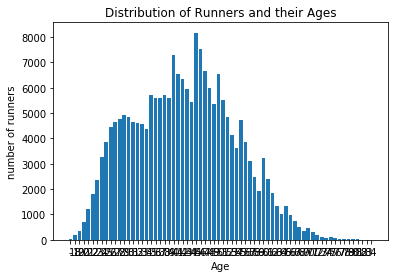

In [32]:
plt.figure()
#X, y are used to create a frequency distribution for the number of runners and their age
x = []
y = []

for key, grp in df.groupby(['Age']) :
    #Populate x and y
    x.append(key)
    y.append(len(grp))
    
#Create a bar graph of the frequencies
plt.bar(x, y)
#Add a title and label the axis
plt.ylabel('number of runners')
plt.xlabel('Age')
plt.title('Distribution of Runners and their Ages')

#Show the plot
plt.show()

# Further Analysis
Now that we have two hypothesis for the spikes in frequencies, we want to try to determine which is more likely to be the cause. 

To do this we will start of by taking a look at the relative frequencies of runner ages within an age group. Using relative frequencies allows us to compare results between different age groups while taking into account different numbers of runners within those age groups. 

To start off this portion of the analysis, we will assign an age group to an individual. We will also be droping any observation that does not have an age, or that has a non-numeric age assigned to it. We will also convert the age column to an integer type instead of a string to allow comparisons and to facilitate graphing. 

In [33]:
#Lists used to group runnders by their age goup
age_bins = [17,34,39,44,49,54,59,64,69,74,79,100]
labels = ['18-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']

#Remove observations that do not have an age
age_df = df.dropna(axis=0, subset=['Age']) 
#Remove observations where age is not a number (misformatted data)
age_df = age_df[df.Age.str.isnumeric()]
df = df[df.Age.str.isnumeric()]
df['Age'] = df.Age.astype('int')

#Cast the age column to be integers so that we can compare ages
age_df['Age'] = age_df['Age'].astype('int64')

#Assign age group to individual. 
age_df['age_group'] = pd.cut(age_df.Age, age_bins, labels=labels)

The following code is used to ensure that the dataframe looks as expected

In [41]:
#Sort the dataframe by age group to get an idea of what it looks like
age_df.sort_values(by='age_group')
age_df.head()

,Bib,Name,Age,MF,City,State,Country,Citizen,,5K,...,30K,35K,40K,Pace,Proj_Time,Overall,Gender,Division,time_minutes,age_group
0,2,"Desisa, Lelisa",23,M,Ambo,NaN,ETH,NaN,NaN,0:15:56,...,1:32:43,1:48:41,2:03:47,0:04:59,2:10:23,1,1,1,130.366667,18-34
1,19,"Kogo, Micah",26,M,Eldoret,NaN,KEN,NaN,NaN,0:15:55,...,1:32:43,1:48:42,2:03:47,0:04:59,2:10:27,2,2,2,130.450000,18-34
2,3,"Gebremariam, Gebregziabher",28,M,Tigray,NaN,ETH,NaN,NaN,0:15:56,...,1:32:43,1:48:42,2:03:47,0:04:59,2:10:27,3,3,3,130.466667,18-34
3,15,"Hartmann, Jason",32,M,Boulder,CO,USA,NaN,NaN,0:15:34,...,1:33:10,1:49:15,2:05:11,0:05:03,2:12:12,4,4,4,132.200000,18-34
4,1,"Korir, Wesley",30,M,Kenya,NaN,KEN,NaN,NaN,0:15:54,...,1:32:58,1:48:47,2:04:46,0:05:04,2:12:30,5,5,5,132.500000,18-34


Now we can group the observations by age group and analyze the data more.

In [34]:
#Group the dataframe by age group so that we can analyze that we can analyzed each age group seperately
age_dfs = age_df.groupby(['age_group'])

Once we have the data split into age groups we can create a relative frequency distribution for each group. The code below first iterates over each age group, then each age within that group to do this.

We plot the percentage of runners a single age are of the total number of runners in that age group.

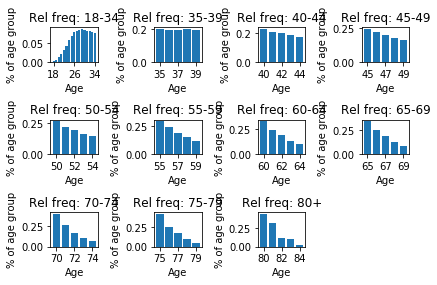

In [36]:
#Create a plot to look at the frequency distributions for runners, this time taking into acount age groups
plt.figure()
i = 1

#Iterate over every age group
for key, grp in age_dfs :
    #Store the number of data points in points, and the age of the runners in x
    points = []
    x = []
    
    #Select the subplot to display the graph on
    plt.subplot(3, 4, i)
    i+=1
    
    #Select appropriate values for the x axis
    if key != '18-34' :
        xint = range(int(grp['Age'].min()), int(grp['Age'].max() + 1), 2)
    else : 
        xint = range(int(grp['Age'].min()), int(grp['Age'].max() + 1), 8)
    plt.xticks(xint)
    
    #Populate the lists for all ages in the given age group
    for key2, grp2 in grp.groupby(['Age']) :
        #Append the age to the x list
        x.append(key2)
        #Append the number of runners with a given age to the points list
        points.append((int(age_df.groupby(['Age']).count().dropna()['Bib'][key2])))
    #We want to be able to compare the distributions across different age groups so we normalize the number of points to make 
    #the distributions relative frequency distributions instead of frequency distributions
    relative_y = []
    for val in points :
        #Normalize each observation by dividing by the number of runners in the age group
        relative_y.append(float(val) / float(len(grp)))
        
    #Create the plot
    plt.bar(x, relative_y)
    #Label axis and title plot
    plt.ylabel('% of age group')
    plt.xlabel('Age')
    plt.title('Rel freq: ' + str(key))
#Remove overlap so that the plot looks better
plt.tight_layout()
#Show the plot
plt.show()

What we see from the previous result is that for the first two age groups (18-34 and 35-39) are different from the other groups. In all other age groups the most frequent age is the lowest age in the group, then the frequency decreases as age increases. But in the first  group (18-34) frequency increases as age increases and in the second group (35-39) frequency is almost contant across all ages in the group.

An interesting thing to note is that the relative frequency decreases as a runner's age gets farther away from the age that humans reach peak performance. Peak performance for endurance sports is reached around the age range of 27-39 years according to https://link.springer.com/article/10.1007/s40279-015-0354-3. So for the 18-34 age group, as age gets closer to 18 and farther from 27 fewer runners are participating in this marathon. Similarly in the 40-44 age group as age gets closer to 44 and farther from 39 fewer runners participate in this marathon. Whereas the frequency of runner participation is almost contant while runners are in their prime (35-39).

This analysis suggests that the decrease in runner participation within age groups is caused by runners being further from their prime and them being less likely to run the qualifying time for the Boston marathon. 

This also suggests that the stronger hypothesis is the one which proposed that a change in time cutoffs between age groups is the cause for spikes in frequencies of runners. If the milestone age hypothesis were true we would expect to see spikes in participation at the ages of 20, 25, 30, and 35 but there are none for those ages. If the time cutoff hypothesis were true, we would expect to see that runners who are closer to their prime are faster than runners in the same age group who are further from their prime. 

To test the cutoff hypothesis further we can look at the average time a runner takes to complete the marathon at a given age and plot that against the times for other ages in the same group. 

# Further testing the time cutoff hypothesis
To further test our hypothesis that the change in time cutoffs is the cause of spikes in the number of runners participating in the Boston marathon we will plot the average time in minutes that it takes a runner to complete the marathon for a given age, then determine if there is a statistically significant trend in the change of this time by using linear regression. 

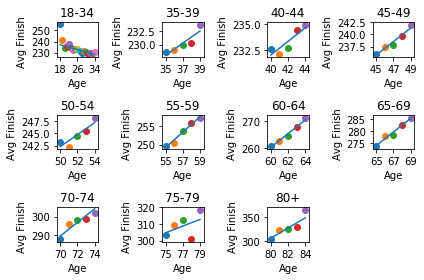

In [37]:
#Create plot of time by age group
plt.figure()
#Values holds the results of a linear regression analysis
values = []
i = 1

#Iterate over every age group
for key, grp in age_dfs :
    #For each age group make a subplot
    plt.subplot(3, 4, i)
    i+=1
    
    #Select appropriate values for the x axis
    if key != '18-34' :
        xint = range(int(grp['Age'].min()), int(grp['Age'].max() + 1), 2)
    else : 
        xint = range(int(grp['Age'].min()), int(grp['Age'].max() + 1), 8)
    plt.xticks(xint)
    
    #Perform a linear regression analysis
    slope, intercept, r_value, p_value, std_err = stats.linregress(grp['Age'], grp['time_minutes'])
    
    #Add the LSRL to the plot
    x = range(int(grp['Age'].min()), int(grp['Age'].max() + 1), 1)
    plt.plot(x, intercept + slope * pd.Series(x), '-')
    
    #Store the results of the regression so that we can analyze them later
    values.append((key, r_value, p_value, slope))
    
    #Iterate over every age in the age group
    for key2, grp2 in grp.groupby(['Age']) :
        #Plot the mean time to complete the marathon for the age
        plt.scatter(key2, grp2['time_minutes'].mean())
        #Label the axis
        plt.xlabel('Age')
        plt.ylabel('Avg Finish ')
    #Title the plot
    plt.title(str(key))
    
#Remove overlap so that the plot looks better
plt.tight_layout()
plt.show()

From the graphs we see that there is a negative correlation between age and time to finish the marathon for the 18-34 age group and a positive correlation between between finish time and age for all of the other age groups. This means that runners further from their prime run slower. These results supports our hypothesis that the spikes in runners we observed are caused by the changes in time cutoffs for the reasons that we explained above.

One thing worth noting is the increase in time to complete the marathon within the 35-39 age group. If we look at the means, the mean of runners age 39 is significantly higher than the other ages in the group. There is room for further analysis to determine what the cause of this increase in time to finish is. 

Below we look at the r values, p values, and slope to confirm that what we observed in the previous step was statistically significant. 

In [39]:
#Print the values obtained from linear regression so that we can analyze them
for v in values :
    print(v[0] + ': r value = ' + str(v[1]) + ' p_value = ' +str(v[2]) + ' slope = ' + str(v[3])) 

18-34: r value = -0.04014636910949393 p_value = 2.7740099436628067e-21 slope = -0.5340025000828846
35-39: r value = 0.03553592610714595 p_value = 2.348557075569302e-09 slope = 1.1409343037776096
40-44: r value = 0.02118420894538825 p_value = 0.00016775336840580982 slope = 0.6516950017018363
45-49: r value = 0.04814781638383862 p_value = 9.098534131763747e-19 slope = 1.3782225622333022
50-54: r value = 0.04172744917143228 p_value = 5.5917211936807833e-11 slope = 1.2180544631325938
55-59: r value = 0.07040103413773081 p_value = 4.326803178545183e-19 slope = 2.0829936302791063
60-64: r value = 0.08601493129300843 p_value = 1.3807255290564284e-17 slope = 2.4838072968138714
65-69: r value = 0.09193343873418122 p_value = 7.555526101883041e-09 slope = 2.8137573542902623
70-74: r value = 0.11144870387733084 p_value = 0.00012997735110120416 slope = 3.7443135847980935
75-79: r value = 0.05301502309278481 p_value = 0.3829103252364967 slope = 1.9893887745273866
80+: r value = 0.24209859827103408 p

The r values suggest that ~.25-1% of the variation in finish time is explained by age for most age groups. This is expected because there are many more variables that have a much larger effect on finish time that we did not and can not account for using the data that we have. Some of the most notable variables that we can not account for include training, diet, injuries, previous running experience, etc. The r values also confirm the correlations metioned in the previous analysis.  

The p value suggests that the correlation between age and finish time is a statistically significant for all age groups except the 75-79 age group and the 80+ age group. The likely reason for no significance in these age groups is because there are very few participants in the boston marathon in these two age groups so we do not have enough data points to determine if there is a strong relationship. 

# Conclusions
From the analysis we found that a likely reason for spikes in the frequency of runners running the boston marathon is the an increase in the time cutoffs as age increases. One possible explanation for this is that when the time cutoff decreases, it is easier for a runner to achieve that time but as they get older with the same cutoff they are less likely to make the cutoff. 

We found that the hypothesis suggesting that a runner will run a marathon when they reach a milestone age is less likely because of a few factors. The first factor that did not match this hypothesis was that some spikes were missing for ages where they were expected. The second observation that did not match this hypothesis was that there were no spikes within age groups where we would have expected to see them, they were only at the boarder between age groups. 

# Potential Applications:
A potential use for this information that we mentioned previously was for marketing. Companies that create running related products that are meant to enhance your performance can target their advertising knowing that runners farther from their prime are slower, and are most likely to run the Boston marathon when they enter a new age bracket. Using that information they could target adds for marathon training gear towards these runners. 

# Further Analysis
If we wanted to do further analysys we could start by taking into account more factors. The next step would be to consider gender and to see if our results would still be the same if we separated the data based by gender. Another thing that we did not look into was the effect of requiring a qualifying time on the milestone hypothesis. To look more into that we could compara the data we have from the boston marathon with data from marathons such as the Philidelphia marathon that allow anyone to register. We also did not take into account runners who raised money to qualify for Boston instead of running a qualifying time. 

Another area of the dataset that we did not look into was the pace of a runner throughout the race. We could look at how a the consistency of a runner's times effects their race results, or look at how likely a runner is to finish based on their pace. We could also determine a way to analyze a runner's motivation (ex. finishing under a certain time, or position) and apply that information to the general public as mentioned in the "Importance" section of this document. 